## Dimensionality Reduction

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

%matplotlib inline

%load_ext autoreload
%autoreload 2

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
data_file = "all_lasso_selected.csv"

In [20]:
from reed import drop_missing_treatment_or_outcome
from direct_regression import seperate_and_transform_data

data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
    
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

Dropped 592 rows missing treatment or outcome.


I did try generating synthetic data from the joint $P(X,T)$, however the hacky approximation doesn't do a great job at capturing the correlation between continuous and binary variables.

In [23]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor

V = np.hstack((t.reshape(-1,1),X))

pred_base = y.mean()*np.ones(len(y))

lr = LinearRegression().fit(V,y) # why is linear regression going crazy here?
lr_pred = lr.predict(V)

lasso = Lasso().fit(V,y)
ls_pred = lasso.predict(V)

ridge = Ridge().fit(V,y)
r_pred = ridge.predict(V)

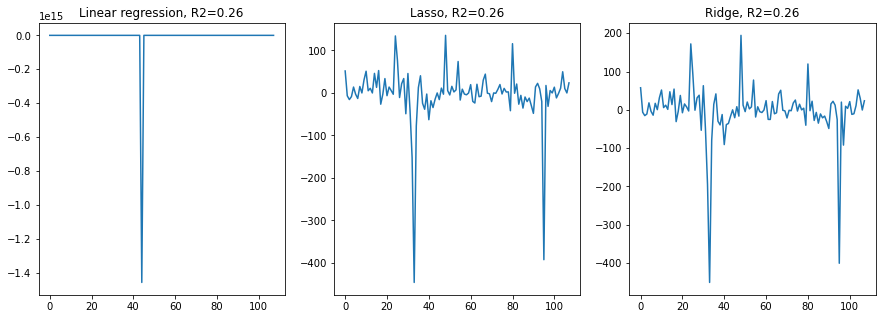

In [24]:
from sklearn.metrics import r2_score
fix, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(lr.coef_)
ax[1].plot(lasso.coef_)
ax[2].plot(ridge.coef_)

ax[0].set_title(f"Linear regression, R2={r2_score(y,lr_pred):.2f}")
ax[1].set_title(f"Lasso, R2={r2_score(y,ls_pred):.2f}")
ax[2].set_title(f"Ridge, R2={r2_score(y, r_pred):.2f}");

In [25]:
from simulations.datagen import generate_sythetic_approximation

def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

def efron_rsquare_scorer(estimator,X,y):
    y_prob = estimator.predict_proba(X)[:,1]
    return efron_rsquare(y,y_prob)
    
def match_empirical_distribution(samples, output_distribution):
    """Transforms the empirical distribution of samples to the output."""
    assert len(samples) == len(output_distribution)
    result = np.zeros(len(samples))
    order = np.argsort(samples)
    values = np.sort(output_distribution)
    result[order] = values
    return result

In [28]:
from sklearn.model_selection import cross_val_score

def generate_sythethic_example(X,t,y):

    model = LogisticRegression()
    model.fit(X,t)
    beta = model.coef_[0]
    p = model.predict_proba(X)[:,1]
    
    V = np.hstack((t.reshape(-1,1),X))
    ridge = Ridge().fit(V,y)

    Xs = generate_sythetic_approximation(X)
    pts = Xs@beta
    ps = match_empirical_distribution(pts, p)
    ts = np.random.binomial(1,ps)

    Vs = np.hstack((ts.reshape(-1,1),Xs))
    ys = Vs@ridge.coef_ + np.random.normal(scale=900,size=len(Vs))
    
    data = pd.DataFrame(Xs, columns = [f"x{i}" for i in range(X.shape[1])])
    data['t'] = ts
    data['p(t=1)']=ps
    data['y']=ys
    
    return data, ridge.coef_

data, coef = generate_sythethic_example(X,t,y)


In [36]:
from reed import regex_select
features = regex_select(data.columns, "^x")
Xs = data[features]
ys = data['y'].values
ts = data['t'].values
model2 = LogisticRegressionCV()
print(cross_val_score(model2, Xs, ts, scoring=efron_rsquare_scorer))
print(cross_val_score(model2, X, t, scoring=efron_rsquare_scorer))

[0.10668757 0.07576619 0.09575329 0.0909263  0.07533682]
[0.04757735 0.09437611 0.09743074 0.08661522 0.1033706 ]


In [37]:
Vs = np.hstack((ts.reshape(-1,1),Xs))
m = LassoCV()
p = m.fit(Vs,ys).predict(Vs)
r2_score(ys,p)

0.2681273781061624

In [38]:
data.to_csv("sythetic_data.scsv")